In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets


import warnings
warnings.simplefilter("ignore")

#try except for chceking, if exist none - if not exist then install
try:
    import chart_studio.plotly as py
except:
    ! pip install --user chart-studio
    import chart_studio.plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


try:
    import seaborn as sns
except:
    ! pip install --user seaborn
    import seaborn as sns

In [3]:
# reading-csv-dataframe 
#df = pd.read_csv("GlobalLandTemperaturesByCity.csv")---original
df = pd.read_csv("/Users/vyadav/Downloads/GlobalLandTemperaturesByCity.csv") #---changed

#date time format converting
df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']


#added axis=1 instead of 1 for correcting the drop command error as it takes only 2 value 
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, axis=1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", axis=1)

# removing all rows with NaN values
df = df.dropna()

cities = set(df.City)

In [4]:


def check_stationarity(city_df):
    # M1: plotting TS to check for trend and seasonality
    #city_df.plot(figsize=(10, 10))
    #replacing with below
    city_df.plot(figsize=(10, 5), title=f"Time Series Plot for {chosen_city}")
    plt.xlabel("Year")
    plt.ylabel("Average Temperature (°C)")
    plt.grid(True)
    plt.tight_layout()

    
    # M2: checking if histogram fitting Gaussian Curve. 
    #city_df.hist(figsize=(10, 10))
    #replacing with below
    city_df.hist(figsize=(10, 5), bins=50, grid=False)
    plt.suptitle(f"Histogram of Temperature for {chosen_city}", fontsize=16)
    plt.xlabel("Average Temperature (°C)")
    plt.ylabel("Frequency")
    plt.tight_layout()

    plt.show()

    #splitting data--2
    #calculating mean and variance 
    #chceking for difference
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # <10(less than)=stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # M3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [5]:
print("Cities list:", cities)

Cities list: {'Chosica, Peru', 'Jinchang, China', 'Khartoum, Sudan', 'Qunduz, Afghanistan', 'Cincinnati, United States', 'Jiaxing, China', 'San Salvador, El Salvador', 'Zaanstad, Netherlands', 'Baripada, India', 'Arad, Romania', 'Sapucaia, Brazil', 'Leganés, Spain', 'Muzaffarnagar, India', 'Dandong, China', 'Lawang, Indonesia', 'Mawlamyine, Burma', 'Makiyivka, Ukraine', 'Raiganj, India', 'Chongqing, China', 'Iligan, Philippines', 'Ponta Grossa, Brazil', 'Reykjavík, Iceland', 'Budapest, Hungary', 'Dordrecht, Netherlands', 'Dezhou, China', 'Garden Grove, United States', 'Kurume, Japan', 'Beipiao, China', 'Jakarta, Indonesia', 'Laohekou, China', 'Nevinnomyssk, Russia', 'Luque, Paraguay', 'Kursk, Russia', 'Jerusalem, Israel', 'Diadema, Brazil', 'Cariacica, Brazil', 'Akita, Japan', 'Ila, Nigeria', 'Shrirampur, India', 'Jinchengjiang, China', 'Sydney, Australia', 'Gombe, Nigeria', 'Cabo Frio, Brazil', 'Sirjan, Iran', 'Tagum, Philippines', 'Baiyin, China', 'Beihai, China', 'Mormugao, India', 

In [6]:
# specific user entered city

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='Blantyre, Malawi',
    description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=395, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', 'A…

In [7]:
chosen_city = city_drop_down_menu.value
#added axis=1 instead of normal 1 for fixing drop command error as it takes only 2 values
city_df = df[df.City == chosen_city].drop("City", axis=1)

Stationarity Check for Blantyre, Malawi


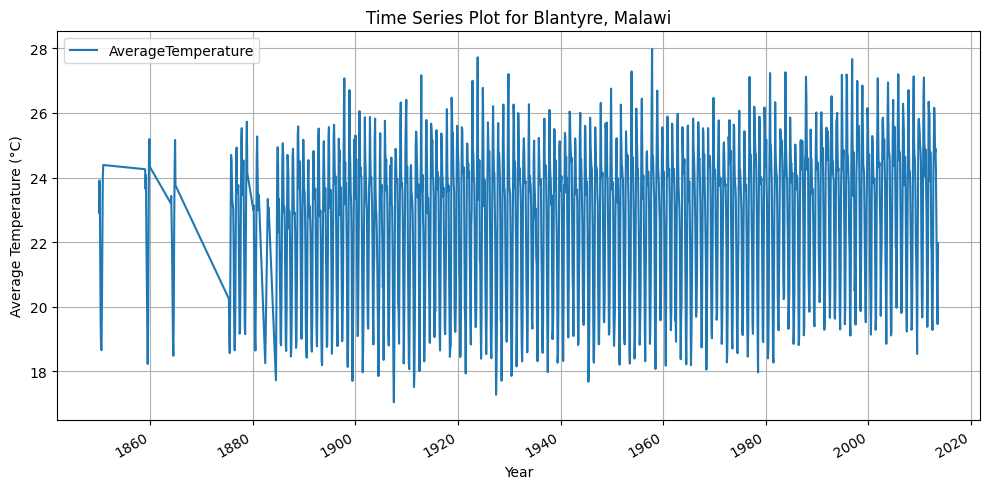

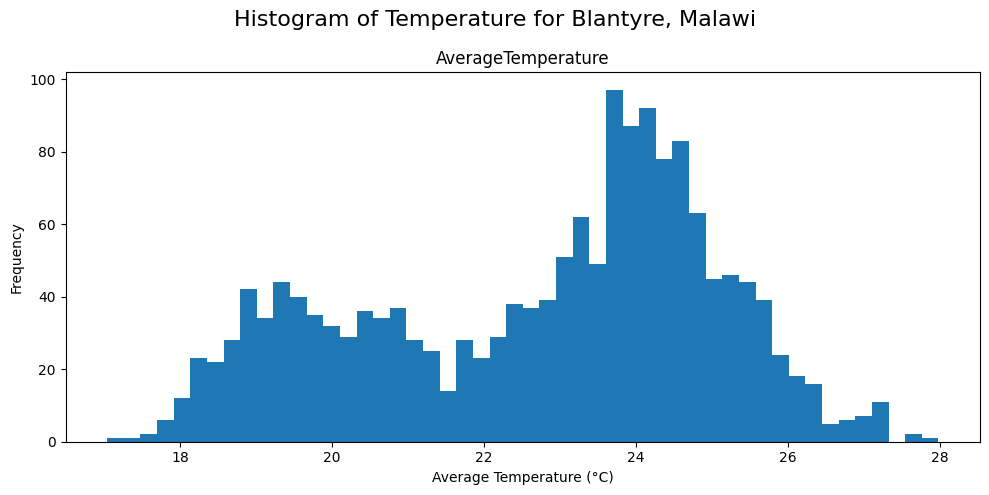

mean1=22.454221, mean2=22.981976
variance1=5.345117, variance2=5.346045
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -3.897702
p-value: 0.002052
Time Series is Stationary, since p-value <= 0.05


In [8]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

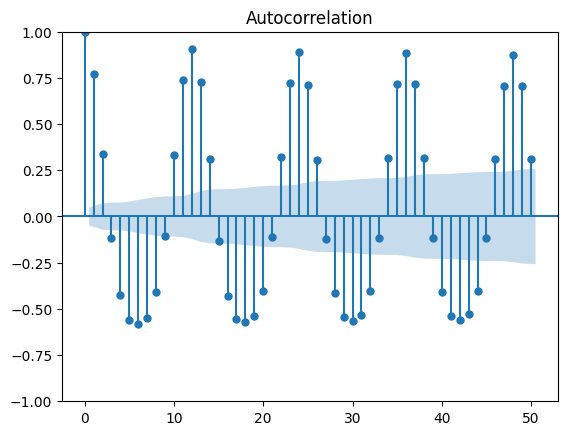

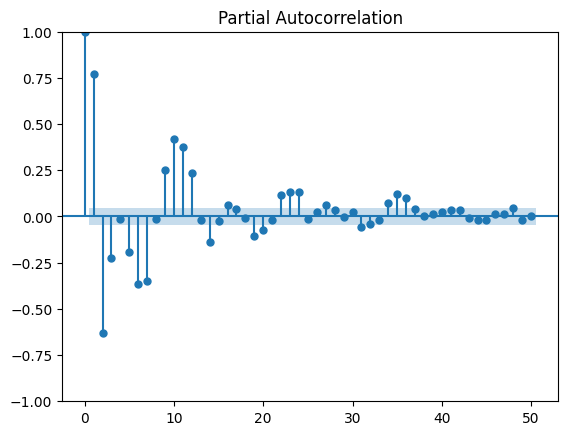

In [9]:
# ACF and PACF plots

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1

In [10]:



p_range = q_range = list(range(0,3))  # from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq =(2,2)
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (2, 2)


In [11]:
# Importing the ARIMA class --> new module
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fitting an ARIMA model with chosen p, d, q values and calculating the MSE
arima_model = ARIMA(city_df['AverageTemperature'], order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

# Calc MSE
mse = mean_squared_error(city_df['AverageTemperature'], predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 1.181797740600836


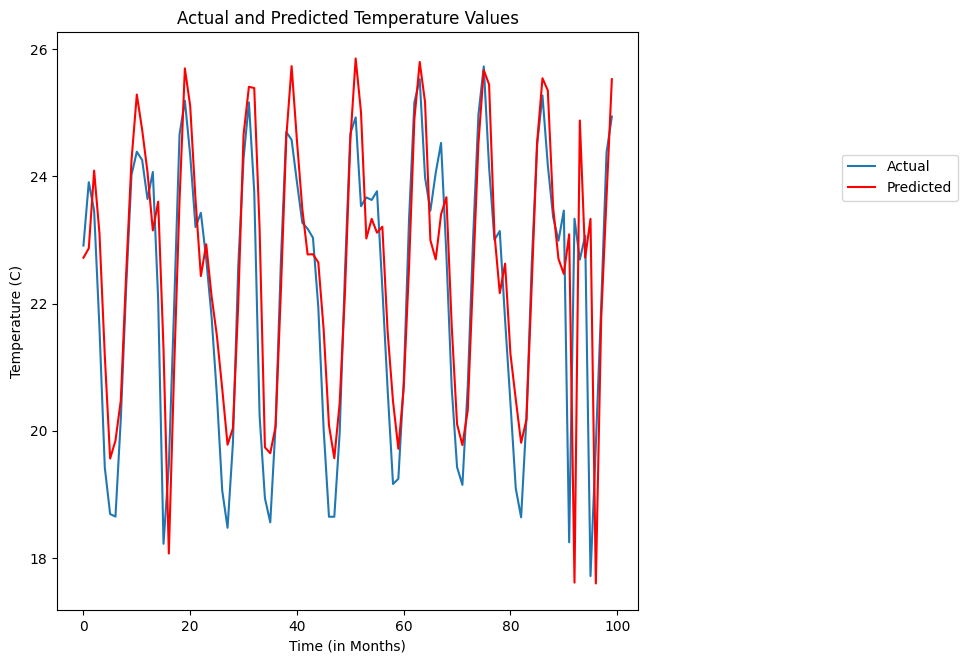

In [12]:
# comparing first 100 predictions with actual values

plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [13]:

years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

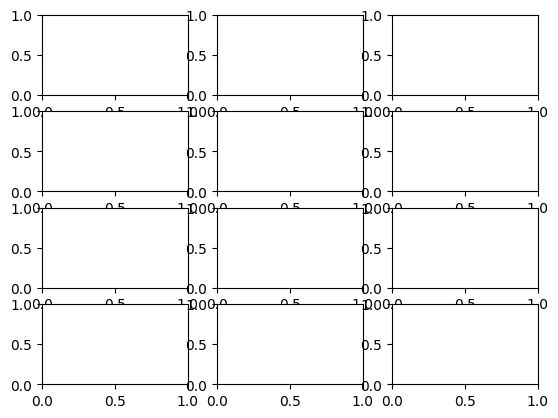

In [14]:
# plotting monthly temperature changes from 2013 to 2013+n years

fig, ax = plt.subplots(nrows=4, ncols=3)

# Get temperature values as dictionary with index as key
out_of_sample_forecast = dict(enumerate(df['AverageTemperature'].tolist()))

 
monthly_change = {}

#defining num_years through the dropdown value we are fetching
num_years = years_drop_down_menu.value

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [out_of_sample_forecast[temp]]
        else:
            monthly_change[month].append(out_of_sample_forecast[temp])
        temp+=12

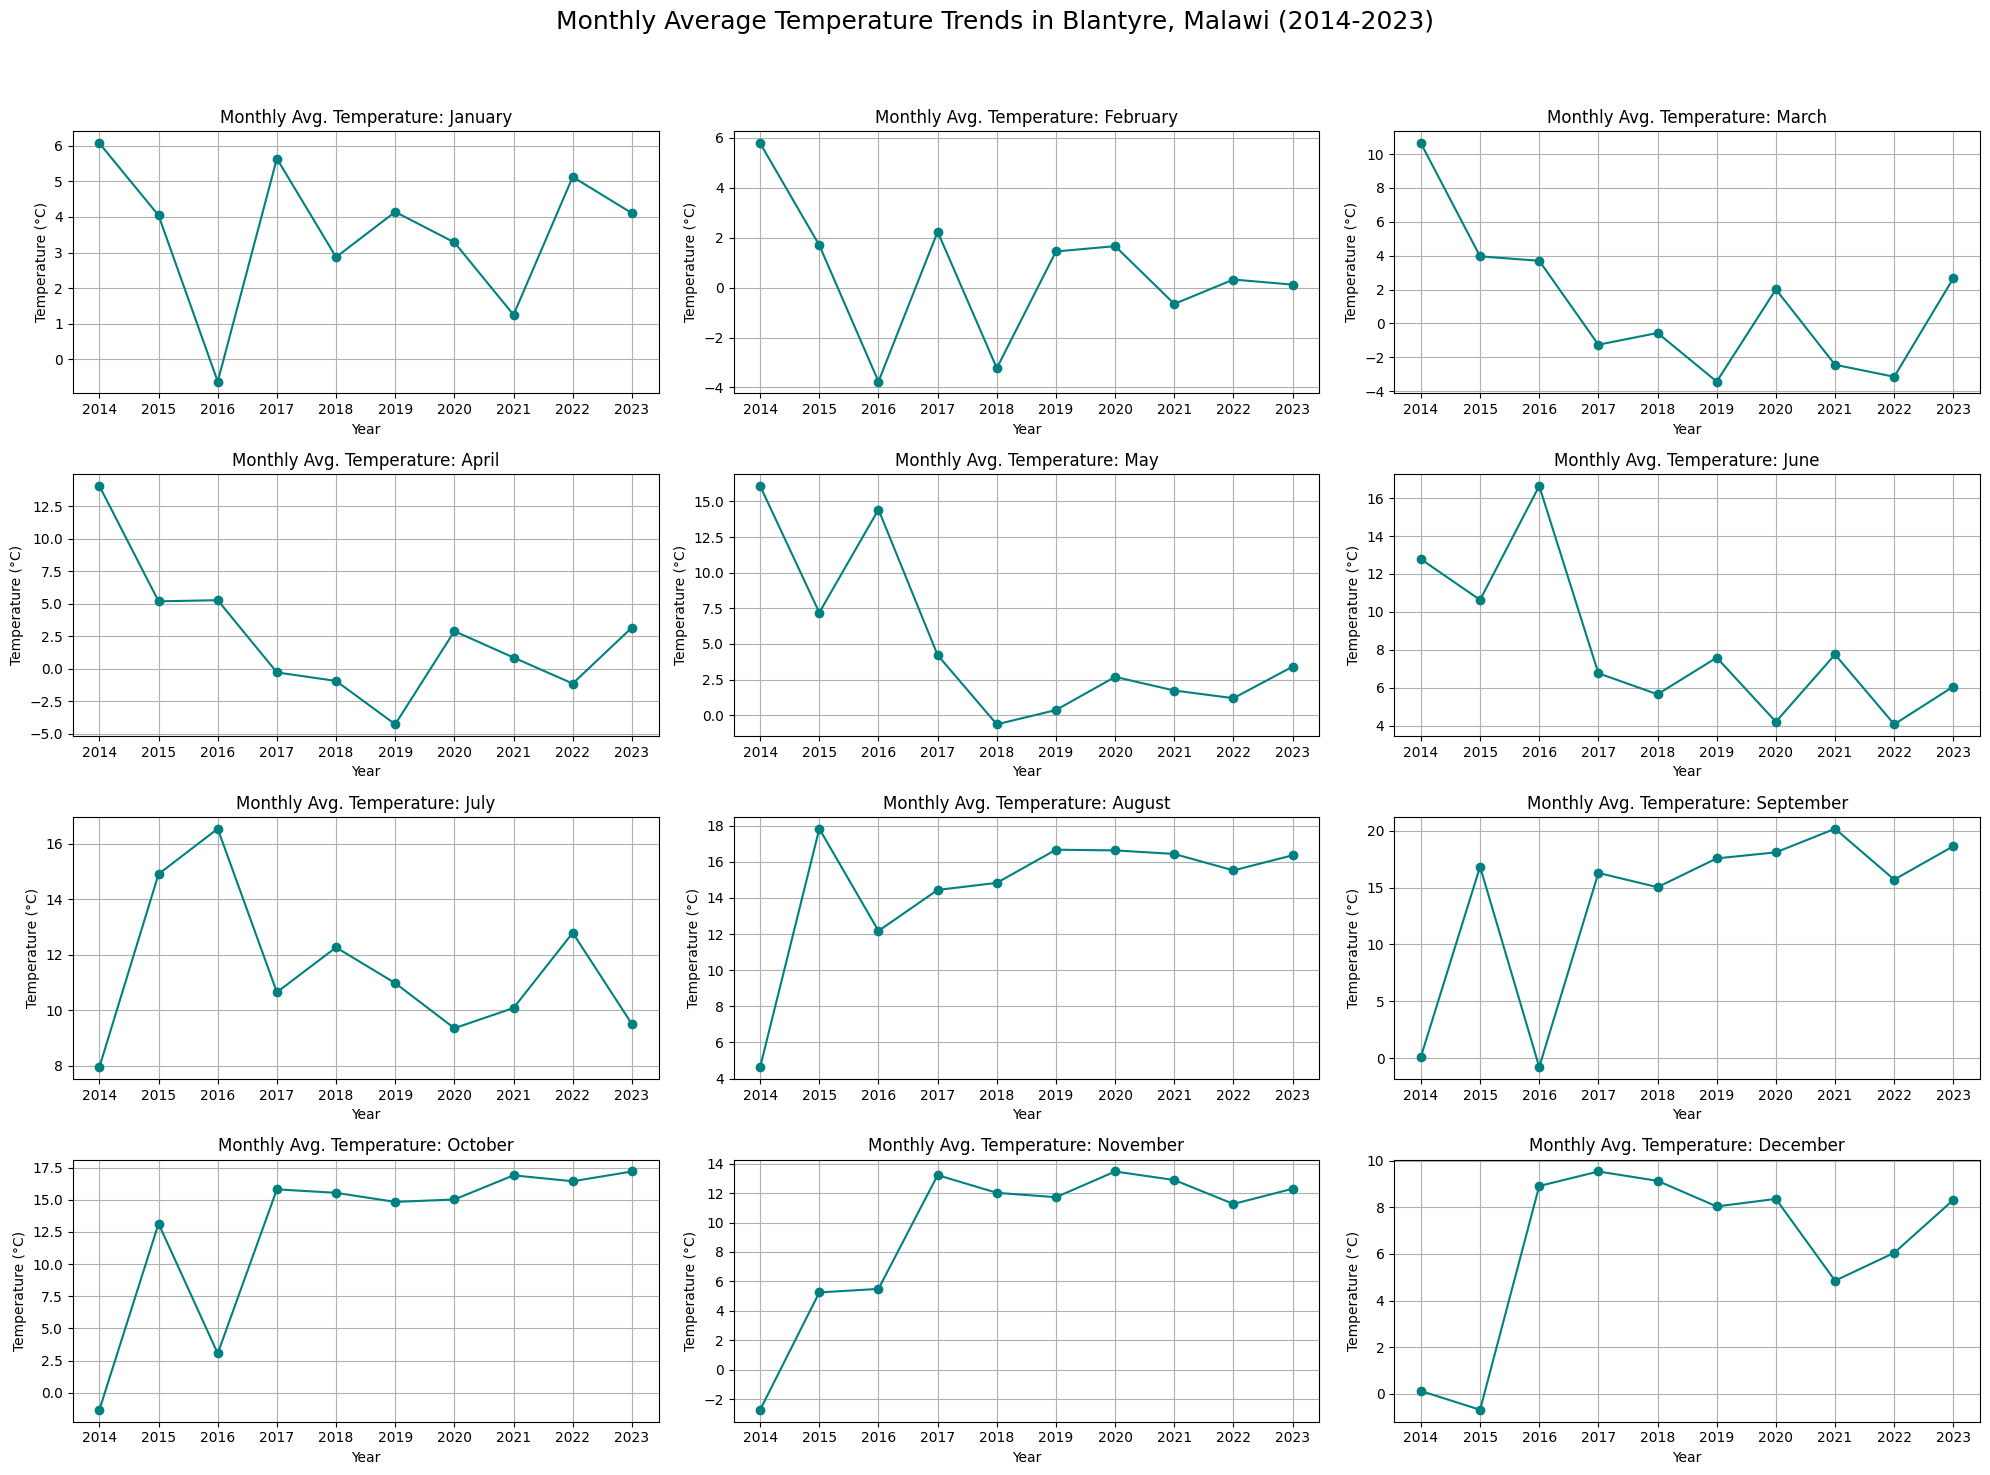

In [15]:
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

#plt.figure(figsize=(20,20))
#for pos in range(0,12):
#    plt.subplot(4,3,pos+1)
#    plt.plot(monthly_change[pos])
#    plt.xticks(np.array(range(num_years)), [i for i in range(2014,2014+num_years)])
#    plt.title(months[pos])
#    plt.xlabel('Years')
#    plt.ylabel('Temperature(C)')

#plt.show()

#replacing with below
plt.figure(figsize=(20, 15))
for pos in range(12):
    plt.subplot(4, 3, pos + 1)
    plt.plot(monthly_change[pos], marker='o', linestyle='-', color='teal')
    plt.xticks(np.array(range(num_years)), [i for i in range(2014, 2014 + num_years)])
    plt.title(f"Monthly Avg. Temperature: {months[pos]}", fontsize=12)
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)

plt.suptitle(f"Monthly Average Temperature Trends in {chosen_city} (2014-{2014 + num_years - 1})", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo

# Define required variables (Example for testing)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tick_vals = [0, 1, 2, 3, 4, 5]  # Replace with your actual tick values (e.g., years)
tick_text = ['2014', '2015', '2016', '2017', '2018', '2019']  # Corresponding text labels for the years
monthly_change = [[0, 1, 2, 3, 4, 5], [0, 1.5, 2.5, 3.5, 4.5, 5.5], [0, 1, 2, 2.5, 3, 4], 
                 [0, 0.5, 1.5, 2.5, 3, 3.5], [0, 1, 1.5, 2, 3, 3.5], [0, 1.2, 2, 2.2, 3, 4],
                 [0, 1, 1.7, 2.5, 3, 3.8], [0, 0.8, 1.5, 2.5, 3.2, 4], [0, 1.5, 2.3, 3.2, 3.5, 4.5],
                 [0, 0.5, 1.2, 1.8, 2.5, 3], [0, 1, 2, 2.8, 3.5, 4], [0, 0.5, 1.3, 2.3, 3, 3.8]]
chosen_city = "Sample City"  # Replace with the actual city name

# Create a figure with 2x3 layout
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f"Monthly Avg. Temperature: {month}" for month in months[:6]],
    horizontal_spacing=0.15,
    vertical_spacing=0.2
)

# Store traces for both groups
group_1_traces = []
group_2_traces = []

# Plot for Group 1 (months 0–5)
row, col = 1, 1
for i in range(6):
    trace = go.Scatter(
        x=tick_vals,
        y=monthly_change[i],
        mode='lines+markers',
        line=dict(color='teal'),
        marker=dict(size=6),
        name=months[i],
        visible=True  # Initially visible
    )
    fig.add_trace(trace, row=row, col=col)
    group_1_traces.append(len(fig.data)-1)

    fig.update_xaxes(
        tickvals=tick_vals,
        ticktext=tick_text,
        tickangle=-90,
        title_text="Year",
        row=row, col=col
    )
    fig.update_yaxes(title_text="Temp (°C)", row=row, col=col)

    col += 1
    if col > 3:
        col = 1
        row += 1

# Add dummy traces for group 2 in same positions, initially hidden
row, col = 1, 1
for i in range(6, 12):
    trace = go.Scatter(
        x=tick_vals,
        y=monthly_change[i],
        mode='lines+markers',
        line=dict(color='orange'),
        marker=dict(size=6),
        name=months[i],
        visible=False  # Hidden initially
    )
    fig.add_trace(trace, row=row, col=col)
    group_2_traces.append(len(fig.data)-1)

    col += 1
    if col > 3:
        col = 1
        row += 1

# Add toggle dropdown
buttons = [
    dict(label="Group 1 (Jan–Jun)",
         method="update",
         args=[{"visible": [i in group_1_traces for i in range(len(fig.data))]},
               {"title": f"Monthly Avg. Temperature Trends in {chosen_city} - Group 1 (Jan–Jun)"}]),

    dict(label="Group 2 (Jul–Dec)",
         method="update",
         args=[{"visible": [i in group_2_traces for i in range(len(fig.data))]},
               {"title": f"Monthly Avg. Temperature Trends in {chosen_city} - Group 2 (Jul–Dec)"}])
]

# Update layout for background and aesthetics
fig.update_layout(
    plot_bgcolor='rgba(240, 240, 240, 0.95)',  # Soft plot area background (light grey)
    paper_bgcolor='rgba(224, 247, 250, 1)',  # Soft light blue background
    font=dict(
        family="Arial, sans-serif",
        size=14,
        color="#333"
    ),
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        linecolor='black',
        title_text="Year"
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        linecolor='black',
        title_text="Temperature (°C)"
    ),
    title=dict(
        text=f"Monthly Avg. Temperature Trends in {chosen_city} - Group 1 (Jan–Jun)",
        font=dict(size=22, color="#2a2a2a"),
        x=0.5
    ),
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.1,
        y=1.15
    )],
    autosize=True,  # Automatically resize the plot based on screen size
    showlegend=True
)

# Show plot
pyo.plot(fig, filename="temperature_toggle_groups.html")


'temperature_toggle_groups.html'